# STAT 159/259 Final Project: NIH Funding by Research, Condition, and Disease Categories

Group Members: Madeline Adee, Nina Dickens, Tina Li. 

### Overview

This project is an analysis of National Institutes of Health (NIH) funding data. Data is provided publicly by the NIH on funding levels by categories (defined by research, condition, or disease). Original data can be accessed [here at the NIH Research Portfolio Online Reporting Tools](https://report.nih.gov/funding/categorical-spending#/) website. 

### Research Questions

- What are the top 10 NIH funding categories in 2019? 
- What Funding  categories have increased/decreased the most during the years that data is available in 2019? 
- What is the relationship between mortality rates and funding by category in 2019? 

### Data Cleaning

We downloaded the excel file available on this website and removed comments at the bottom to facilitate reading the data, but no changes were made to the raw data at this state. This modified file with no comments is saved here: data/raw_data/funding_data.csv. 

To use the data effectively, we had to do some data cleaning. The NIH used various symbols in place of coding data as missing or unavailable, so these symbols have been removed and these cells coded as missing. 

In [1]:
import pandas as pd
import numpy as np
import h5py
import plotly.express as px

In [4]:
# load data
df = pd.read_csv (r'data/raw_data/funding_data.csv')

# replace + and - and * so they are coded as missing
df = df.replace('+', np.NaN, regex=False)
df = df.replace('-', np.NaN, regex=False)
df = df.replace('*', np.NaN, regex=False)

Next we removed years prior to 2011 (because there was an additional column for two of the years < 2011 without a clear explanation of how to interpret this column) and years after 2020 (since this data was projections only). This gives us a database of 10 years of funding data. However, since prevalence and mortality data are provided only for 2019, we decided to use this year as our endpoint year for analyses.

In [5]:
# remove pre-2011 data and years that are estimates only
df = df.drop(df.columns[[1, 2, 3, 4, 5, 16, 17]], axis=1)

The original data included dollar signs which needed to be removed. Once this is done we have a cleaned data set with the category, a column for each year in the 10 year period (with dollar amounts in millions), and 2019 prevalence and mortality data for conditions/disease for which this was provided.

In [14]:
# list of years to edit the way dollar amount is entered (remove $ sign)
years = ['2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

# remove $ sign
df[years] = df[years].replace('[\$,]', '', regex=True).astype(float)

# remove , in mortality
df['2019_US_Mortality_19'] = df['2019_US_Mortality_19'].replace('[,,]', '', regex=True).astype(float)

pd.to_numeric(df['2019_US_Mortality_19'])

# display data frame in notebook
display(df)

,research_category,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2019_US_Mortality_19,2019_US_Prevalence_SE_19
0,Acquired Cognitive Impairment,NaN,NaN,NaN,NaN,798.0,1132.0,1560.0,1978.0,2423.0,2897.0,NaN,NaN
1,Acute Respiratory Distress Syndrome,96.0,98.0,95.0,85.0,108.0,103.0,107.0,123.0,126.0,158.0,10482.0,NaN
2,Adolescent Sexual Activity,69.0,76.0,70.0,68.0,85.0,91.0,99.0,96.0,102.0,88.0,NaN,NaN
3,Agent Orange & Dioxin,8.0,8.0,10.0,8.0,9.0,9.0,11.0,10.0,8.0,6.0,NaN,NaN
4,Aging,2572.0,2593.0,2429.0,2556.0,2698.0,3150.0,3572.0,4084.0,4653.0,5276.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,West Nile Virus,65.0,29.0,40.0,48.0,40.0,46.0,42.0,36.0,24.0,27.0,90.0,NaN
295,Women's Health 8,3891.0,3833.0,3745.0,3935.0,3989.0,4540.0,4769.0,5048.0,4469.0,4466.0,NaN,NaN
296,Wound Healing and Care,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0,NaN,NaN
297,Youth Violence,87.0,77.0,70.0,59.0,47.0,46.0,50.0,46.0,48.0,38.0,NaN,NaN


We saved this cleaned up data set in hdf5 format.

In [7]:
# Export the pandas DataFrame into HDF5
h5File = "data/cleaned_data/funding_data.hdf5"
df.to_hdf(h5File, "/data/cleaned_data")

/home/jovyan/envs/nih/lib/python3.9/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['research_category', '2019_US_Mortality_19',
       '2019_US_Prevalence_SE_19'],
      dtype='object')]

  pytables.to_hdf(


Then we created another version of the data with the prevalence and mortality removed, including a version in long format. 

In [15]:
# remove mortality and prevalence data for this dataset
df2 = df.drop(['2019_US_Mortality_19', '2019_US_Prevalence_SE_19'], axis = 1)

# Export the pandas DataFrame into HDF5
h5File2 = "data/cleaned_data/funding_data_MP_removed.hdf5"
df2.to_hdf(h5File2, "/data/cleaned_data")

In [16]:
# create long format version of the above dataset
df2_long = pd.melt(df2, id_vars='research_category', 
                   value_vars=['2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'], 
                   var_name = 'year', value_name = 'millions')

# Export the pandas DataFrame into HDF5
h5File3 = "data/cleaned_data/funding_data_MP_removed_long.hdf5"
df2_long.to_hdf(h5File3, "/data/cleaned_data")

# diplay long format data
display(df2_long)

,research_category,year,millions
0,Acquired Cognitive Impairment,2011,NaN
1,Acute Respiratory Distress Syndrome,2011,96.0
2,Adolescent Sexual Activity,2011,69.0
3,Agent Orange & Dioxin,2011,8.0
4,Aging,2011,2572.0
...,...,...,...
2985,West Nile Virus,2020,27.0
2986,Women's Health 8,2020,4466.0
2987,Wound Healing and Care,2020,163.0
2988,Youth Violence,2020,38.0


Next we also tried to make a version of the data where the amount in millions is adjusted for inflation - but the cpi package did not work (might fix later if i have time -- Maddy)

In [34]:
#pd.to_datetime(df2_long['year'])

#display(df2_long)

#df2_long['adjusted_millions'] = df2_long.apply(lambda x: cpi.inflate(x.millions, x.year), axis=1)

In [17]:
df3 = df[['research_category', '2019_US_Mortality_19', '2019']]

# Export the pandas DataFrame into HDF5
h5File4 = "data/cleaned_data/funding_data_2019.hdf5"
df3.to_hdf(h5File4, "/data/cleaned_data")

,research_category,year,millions
0,Acquired Cognitive Impairment,2011,NaN
1,Acute Respiratory Distress Syndrome,2011,96.0
2,Adolescent Sexual Activity,2011,69.0
3,Agent Orange & Dioxin,2011,8.0
4,Aging,2011,2572.0
...,...,...,...
2985,West Nile Virus,2020,27.0
2986,Women's Health 8,2020,4466.0
2987,Wound Healing and Care,2020,163.0
2988,Youth Violence,2020,38.0


#### *Reproducibility Critique of Data Set*

### Analysis

#### *Top 10 Funding Categories in 2019*

Insert description of analysis here.

In [ ]:
# insert code here

#### *Top 5 Funding Categories Over Time*

Insert description of analysis here. 

In [ ]:
# insert code here

#### *Relationship Between Spending and Mortality*

Insert description of analysis here. 

In [19]:
# Use pandas again to read data from the hdf5 file to the pandas DataFrame
df2019 = pd.read_hdf(h5File4, "/data/cleaned_data")

# select only the sample with no missing values for mortality or funding level
df2019.dropna()


,research_category,2019_US_Mortality_19,2019
1,Acute Respiratory Distress Syndrome,10482.0,126.0
5,"Alcoholism, Alcohol Use and Health 1",87566.0,556.0
6,Allergic Rhinitis (Hay Fever),98.0,7.0
8,Alzheimer's Disease,146659.0,2240.0
12,Anorexia,124.0,11.0
...,...,...,...
275,Transmissible Spongiform Encephalopathy (TSE),658.0,34.0
277,Tuberculosis,982.0,488.0
279,Tuberous Sclerosis,59.0,25.0
284,Uterine Cancer,13036.0,36.0


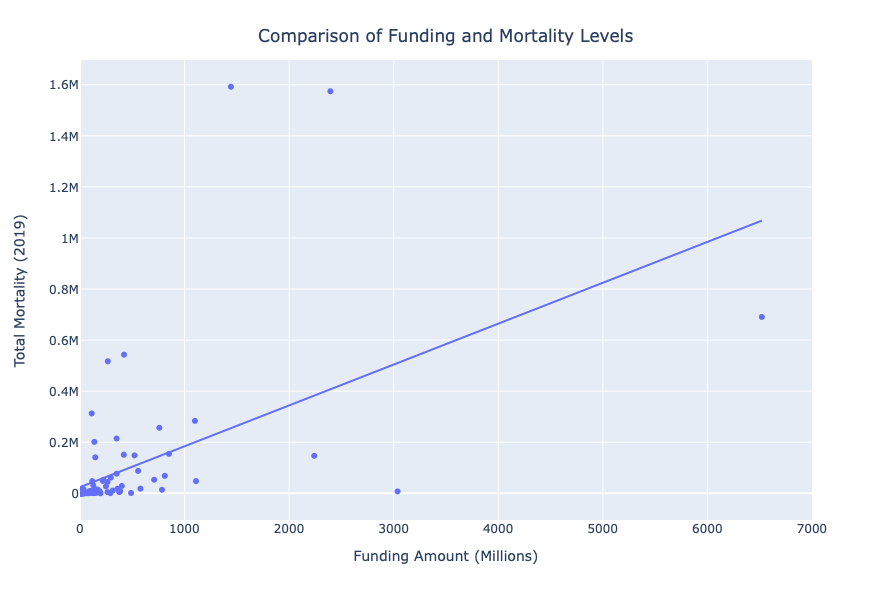

In [32]:
fig = px.scatter(df2019, x="2019", y="2019_US_Mortality_19", hover_data=['research_category'], 
                trendline="ols", 
                labels={
                     "2019_US_Mortality_19": "Total Mortality (2019)",
                     "research_category": "Research Category",
                     "2019": "Funding Amount (Millions)"
                 }, 
                width=800, height=600)


fig.update_layout(
    title={
        'text': "Comparison of Funding and Mortality Levels",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_layout(xaxis_range=[0,7000])

fig.show()